### [Only In Google Colab] Setup TiRex in Colab

Make sure that you selected a **GPU runtime in Google Colab**
Runtime ->  Change Runtime Type -> Select A100 / L4 / T4

In [1]:
# Only for Google Colab Notebook!

import os

# Clone TiRep Repo
!git clone https://github.com/NX-AI/tirex

# Install TiRex
os.chdir('/content/tirex')
!pip install .[gluonts]

# Set Workin Dir to notebooks folder
os.chdir('/content/tirex/examples')

Cloning into 'tirex'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 50 (delta 10), reused 49 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 54.81 KiB | 4.98 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Processing /content/tirex
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports and Load Data

In [2]:
from pathlib import Path

import numpy as np
import torch
from util_plot import plot_fc

# import os
# os.environ["TIREX_NO_CUDA"] = "1"   # Experimental!!: Turns off sLSTM CUDA kernels if you have problems but be aware of the downsides! (see repository FAQ)
from tirex import ForecastModel, load_model
model = load_model("NX-AI/TiRex")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.ckpt:   0%|          | 0.00/141M [00:00<?, ?B/s]

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS512BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/di

### TiRex Forecast in 2 Lines

1) Load Model
2) Generate Forecast

In [4]:
import yfinance as yf
import numpy as np
from datetime import datetime
import pandas as pd

# === Parameters ===
INTERVAL = "1h"
CONTEXT_LEN = 48         # Use 48 hours as input context
PREDICTION_LEN = 3       # Predict 3 hours ahead
SPREAD = 0.03
THRESHOLD = 0.02

# === Load latest data ===
df = yf.download("JPY=X", period="5d", interval=INTERVAL)
series = df['Close'].dropna().reset_index(drop=True).to_numpy()
import pytz

# === Timezone and Entry/Exit Time Calculation ===
latest_candle_time_utc = df.index[-1]
latest_candle_time_tokyo = latest_candle_time_utc.tz_convert('Asia/Tokyo')

# Entry = next hour after latest candle
target_entry_time_utc = latest_candle_time_utc + pd.Timedelta(hours=1)
target_entry_time_tokyo = target_entry_time_utc.tz_convert('Asia/Tokyo')

# Exit = entry + prediction_len hours
exit_time_utc = target_entry_time_utc + pd.Timedelta(hours=PREDICTION_LEN)
exit_time_tokyo = exit_time_utc.tz_convert('Asia/Tokyo')

# Local time now in Tokyo
now_tokyo = datetime.now(pytz.timezone("Asia/Tokyo"))

# === Extract timestamp info ===
last_ctx_index = -(PREDICTION_LEN + 1)
gmt_plus_2 = pytz.timezone('Etc/GMT-2')  # Note: 'Etc/GMT-2' is actually UTC+2
latest_candle_time_gmt2 = latest_candle_time_utc.tz_convert(gmt_plus_2)
predicting_from_time_utc = df.index[last_ctx_index]  # Last timestamp in context
predicting_from_time_local = predicting_from_time_utc.tz_convert('Asia/Tokyo')  # your local time
exit_time_local = predicting_from_time_local + pd.Timedelta(hours=PREDICTION_LEN)

# === Use only most recent window ===
ctx_s = series[-(CONTEXT_LEN + PREDICTION_LEN):-PREDICTION_LEN]

# === Normalize ===
ctx_mean = ctx_s.mean()
ctx_std = ctx_s.std()
ctx_s_norm = (ctx_s - ctx_mean) / ctx_std

# === Load model and forecast ===
quantiles, _ = model.forecast(ctx_s_norm, prediction_length=PREDICTION_LEN)

# === Extract prediction ===
def extract_median_forecast(quantiles):
    median_index = 4  # 0.5 quantile
    forecast_norm = []
    for q in quantiles:
        q = np.array(q).flatten()
        if len(q) > median_index:
            forecast_norm.append(q[median_index])
        else:
            forecast_norm.append(q[0])
    return np.array(forecast_norm)

forecast_norm = extract_median_forecast(quantiles)
forecast = forecast_norm * ctx_std + ctx_mean
forecast = np.clip(forecast, 110, 160)
forecast_trend = forecast[-1] - forecast[0]
prediction = forecast.mean()
current_price = float(ctx_s[-1])

# === Generate trading decision ===
if forecast_trend > THRESHOLD:
    signal = "SHORT (contrarian)"
elif forecast_trend < -THRESHOLD:
    signal = "BUY (contrarian)"
else:
    signal = "FLAT"

# === Output ===
from_zone = 'Asia/Tokyo'  # set your local timezone


print("=== TiRex 1H Forecast ===")
print(f"📈 Latest Candle (UTC):       {latest_candle_time_utc.strftime('%Y-%m-%d %H:%M')}")
print(f"🕑 Latest Candle (GMT+2):     {latest_candle_time_gmt2.strftime('%Y-%m-%d %H:%M')}")
print(f"📈 Latest Candle (Tokyo):     {latest_candle_time_tokyo.strftime('%Y-%m-%d %H:%M')}")
print(f"🎯 Target Entry Time (Tokyo): {target_entry_time_tokyo.strftime('%Y-%m-%d %H:%M')}")
print(f"📅 Target Exit Time (Tokyo):  {exit_time_tokyo.strftime('%Y-%m-%d %H:%M')}")
print(f"🕐 Local Time Now (Tokyo):    {now_tokyo.strftime('%Y-%m-%d %H:%M')}")
print(f"Current Price:  {current_price:.3f}")
print(f"Predicted Mean: {prediction:.3f}")
print(f"Forecast Trend: {forecast_trend:.4f}")
print(f"Suggested Trade: {signal}")


[*********************100%***********************]  1 of 1 completed

=== TiRex 1H Forecast ===
📈 Latest Candle (UTC):       2025-06-10 11:00
🕑 Latest Candle (GMT+2):     2025-06-10 13:00
📈 Latest Candle (Tokyo):     2025-06-10 20:00
🎯 Target Entry Time (Tokyo): 2025-06-10 21:00
📅 Target Exit Time (Tokyo):  2025-06-11 00:00
🕐 Local Time Now (Tokyo):    2025-06-10 20:44
Current Price:  144.646
Predicted Mean: 144.549
Forecast Trend: 0.7395
Suggested Trade: SHORT (contrarian)



<ipython-input-4-be4eacf9ed5e>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_price = float(ctx_s[-1])


In [5]:
print("Now UTC:                     ", datetime.utcnow().strftime('%Y-%m-%d %H:%M'))
print("Latest candle in df (UTC):   ", df.index[-1].strftime('%Y-%m-%d %H:%M'))
print("Latest price:                ", df['Close'].iloc[-1])


Now UTC:                      2025-06-10 11:45
Latest candle in df (UTC):    2025-06-10 11:00
Latest price:                 Ticker
JPY=X    144.520996
Name: 2025-06-10 11:00:00+00:00, dtype: float64


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
<ipython-input-7-ecb79cffc5c3>:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "pnl": float(pnl)


=== Backtest Summary ===
Total Trades:     648
Win Rate:         39.97%
Total PnL:        -21.431
Avg PnL per Trade:-0.0331
Max Drawdown:     23.920


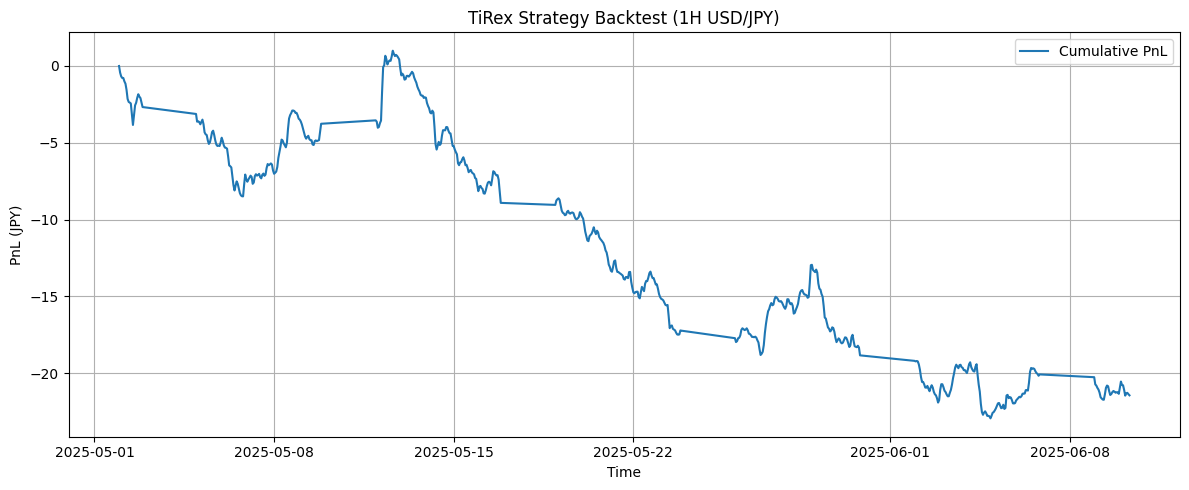

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tirex import load_model

# === Parameters ===
INTERVAL = "1h"
CONTEXT_LEN = 48
PREDICTION_LEN = 3
SPREAD = 0.03
THRESHOLD = 0.02

# === Load historical data ===
df = yf.download("JPY=X", period="30d", interval=INTERVAL)
df = df.dropna().reset_index()
series = df['Close'].to_numpy()

# === Load TiRex model ===
model = load_model("NX-AI/TiRex")

# === Helper to extract median forecast ===
def extract_median_forecast(quantiles):
    median_index = 4  # 0.5 quantile
    forecast_norm = []
    for q in quantiles:
        q = np.array(q).flatten()
        if len(q) > median_index:
            forecast_norm.append(q[median_index])
        else:
            forecast_norm.append(q[0])
    return np.array(forecast_norm)

# === Backtest loop ===
results = []
for i in range(CONTEXT_LEN, len(series) - PREDICTION_LEN):
    ctx_s = series[i - CONTEXT_LEN:i]
    fut_s = series[i:i + PREDICTION_LEN]

    ctx_mean = ctx_s.mean()
    ctx_std = ctx_s.std()
    ctx_s_norm = (ctx_s - ctx_mean) / ctx_std

    quantiles, _ = model.forecast(ctx_s_norm, prediction_length=PREDICTION_LEN)
    forecast_norm = extract_median_forecast(quantiles)
    forecast = forecast_norm * ctx_std + ctx_mean

    if forecast_trend > THRESHOLD:
        signal = "BUY"     # Follow the trend
    elif forecast_trend < -THRESHOLD:
        signal = "SHORT"   # Follow the trend
    else:
        signal = "FLAT"

    #Covirarian Strategy
    '''forecast_trend = forecast[-1] - forecast[0]
    signal = "FLAT"
    if forecast_trend > THRESHOLD:
        signal = "SHORT"
    elif forecast_trend < -THRESHOLD:
        signal = "BUY"'''

    entry_price = series[i]
    exit_price = series[i + PREDICTION_LEN - 1]
    pnl = 0
    if signal == "BUY":
        pnl = exit_price - entry_price - SPREAD
    elif signal == "SHORT":
        pnl = entry_price - exit_price - SPREAD

    results.append({
        "timestamp": df['Datetime'].iloc[i],
        "signal": signal,
        "entry_price": entry_price,
        "exit_price": exit_price,
        "forecast_trend": forecast_trend,
        "pnl": float(pnl)
    })

# === Convert to DataFrame and calculate metrics ===
backtest_df = pd.DataFrame(results)
backtest_df['cumulative_pnl'] = backtest_df['pnl'].cumsum()
total_trades = len(backtest_df[backtest_df.signal != "FLAT"])
win_rate = (backtest_df[backtest_df.pnl > 0].shape[0] / total_trades) if total_trades > 0 else 0

# === Output Summary ===
print("=== Backtest Summary ===")
print(f"Total Trades:     {total_trades}")
print(f"Win Rate:         {win_rate:.2%}")
print(f"Total PnL:        {backtest_df.pnl.sum():.3f}")
print(f"Avg PnL per Trade:{backtest_df.pnl.mean():.4f}")
drawdown = (backtest_df['cumulative_pnl'].cummax() - backtest_df['cumulative_pnl']).max()
print(f"Max Drawdown:     {drawdown:.3f}")

# === Plot Cumulative PnL ===
plt.figure(figsize=(12, 5))
plt.plot(backtest_df['timestamp'], backtest_df['cumulative_pnl'], label="Cumulative PnL")
plt.xlabel("Time")
plt.ylabel("PnL (JPY)")
plt.title("TiRex Strategy Backtest (1H USD/JPY)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Input Options

TiRex supports forecasting with different input types

In [ ]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Torch tensor (2D or 1D)
quantiles, means = model.forecast(context=data, prediction_length=24)
print("Predictions (Torch tensor):\n", type(quantiles), quantiles.shape)

# List of Torch tensors (List of 1D) - will be padded
list_torch_data = [data, data, data]
quantiles, means = model.forecast(context=list_torch_data, prediction_length=24, batch_size=2)
print("Predictions (List of Torch tensors):\n", type(quantiles), quantiles.shape)

# NumPy array (2D or 1D)
quantiles, means = model.forecast(context=data.numpy(), prediction_length=24, output_type="torch")
print("Predictions (NumPy):\n", type(quantiles), quantiles.shape)


# List of NumPy arrays (List of 1D) - will be padded
list_numpy_data = [data.numpy()]  # Split into 3 sequences
quantiles, means = model.forecast(context=list_numpy_data, prediction_length=24)
print("Predictions (List of NumPy arrays):\n", type(quantiles), quantiles.shape)


# GluonTS Dataset
try:
    from typing import cast

    from gluonts.dataset import Dataset

    gluon_dataset = cast(Dataset, [{"target": data, "item_id": 1}, {"target": data, "item_id": 22}])
    quantiles, means = model.forecast_gluon(gluon_dataset, prediction_length=24)
    print("Predictions GluonDataset:\n", type(quantiles), quantiles.shape)
    # If you use also `glutonts` as your output type the start_time and item_id get preserved accordingly
    predictions_gluon = model.forecast_gluon(gluon_dataset, prediction_length=24, output_type="gluonts")
    print("Predictions GluonDataset:\n", type(predictions_gluon), type(predictions_gluon[0]))
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]
    pass

### Output Options


TiRex supports different output types for the forecasts

In [ ]:
data = torch.tensor(np.genfromtxt(Path.cwd() / "air_passengers.csv"))  # Load Example

# Default: 2D Torch tensor
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="torch")
print("Predictions:\n", type(quantiles), quantiles.shape)


# 2D Numpy Array
quantiles, means = model.forecast(context=data, prediction_length=24, output_type="numpy")
print("Predictions:\n", type(quantiles), quantiles.shape)


# Iterate by patch
# You can also use the forecast function as iterable. This might help with big datasets. All output_types are supported
for i, fc_batch in enumerate(
    model.forecast(context=[data, data, data, data, data], batch_size=2, output_type="torch", yield_per_batch=True)
):
    quantiles, means = fc_batch
    print(f"Predictions batch {i}:\n", type(quantiles), quantiles.shape)


try:
    # QuantileForecast (GluonTS)
    predictions_gluonts = model.forecast(context=data, prediction_length=24, output_type="gluonts")
    print("Predictions (GluonTS Quantile Forecast):\n", type(predictions_gluon), type(predictions_gluon[0]))
    predictions_gluonts[0].plot()
except Exception as e:
    print(e)
    # To use the gluonts function you need to install the optional dependency
    # pip install tirex[gluonts]